In [1]:
import numpy as np
DTYPE = np.float64

import matplotlib.pyplot as plt

import os

from tqdm import tqdm

from numba import jit

import pandas as pd

In [2]:
@jit
def floryHuggins(phi:DTYPE, chi:DTYPE):
    res = phi*np.log(phi) + (1-phi)*np.log(1-phi) + chi*phi*(1-phi)
    return res

In [3]:
class mcmc:
    def __init__(self, dof, size, phi_1_global, chi, beta):
        self.dof = dof
        self.size = size # Mesh size
        self.epsilon = 1/self.size # Minimum tolerance according to mesh size
        self.phi_1_global = phi_1_global
        self.chi = chi
        self.beta = beta # Walker's temperature

    def createMesh(self):
        mesh = np.zeros((self.dof, self.size))
        
        for row in range(self.dof):
            mesh[row] = np.linspace(self.epsilon, 1 - self.epsilon, self.size)

        return mesh
        
    def metropolisStep(self, current_idx_phi_11, current_idx_eta_1):

        mesh = self.createMesh()
        
        current_phi_12 = (self.phi_1_global - mesh[1][current_idx_eta_1]*mesh[0][current_idx_phi_11])/(1-mesh[1][current_idx_eta_1])
        
        current_f1 = floryHuggins(mesh[0][current_idx_phi_11], self.chi)
        current_f2 = floryHuggins(current_phi_12, self.chi)

        current_f = mesh[1][current_idx_eta_1]*current_f1 + (1-mesh[1][current_idx_eta_1])*current_f2
        
        proposal_idx_phi_11 = 0
        proposal_idx_eta_1 = 0
        
        # Forcing the walker to move away from the boundaries
        if (current_idx_phi_11 == self.size-1):
            proposal_idx_phi_11 = current_idx_phi_11 - 1
            proposal_idx_eta_1 = current_idx_eta_1
            
        elif (current_idx_phi_11 == 0):
            proposal_idx_phi_11 = current_idx_phi_11 + 1
            proposal_idx_eta_1 = current_idx_eta_1
        
        elif (current_idx_eta_1 == self.size-1):
            proposal_idx_phi_11 = current_idx_phi_11
            proposal_idx_eta_1 = current_idx_eta_1 -1
        
        elif (current_idx_eta_1 == 0):
            proposal_idx_phi_11 = current_idx_phi_11
            proposal_idx_eta_1 = current_idx_eta_1 + 1 

        # Choosing the next move randomly
        else:
            p = np.random.uniform(0, 1)

            if p <= 0.25:
                proposal_idx_phi_11 = current_idx_phi_11 + 1
                proposal_idx_eta_1 = current_idx_eta_1
                
            elif p <= 0.50:
                proposal_idx_phi_11 = current_idx_phi_11 - 1
                proposal_idx_eta_1 = current_idx_eta_1
                
            elif p <= 0.75:
                proposal_idx_phi_11 = current_idx_phi_11
                proposal_idx_eta_1 = current_idx_eta_1 + 1
            
            else:
                proposal_idx_phi_11 = current_idx_phi_11
                proposal_idx_eta_1 = current_idx_eta_1 - 1

        proposal_phi_12 = (self.phi_1_global - mesh[1][proposal_idx_eta_1]*mesh[0][proposal_idx_phi_11])/(1-mesh[1][proposal_idx_eta_1])

        if proposal_phi_12 <= 1-self.epsilon and proposal_phi_12 >= 0+self.epsilon:
            proposal_f1 = floryHuggins(mesh[0][proposal_idx_phi_11], self.chi)
            proposal_f2 = floryHuggins(proposal_phi_12, self.chi)
    
            proposal_f = mesh[1][proposal_idx_eta_1]*proposal_f1 + (1-mesh[1][proposal_idx_eta_1])*proposal_f2
    
            delta_f = proposal_f - current_f
    
            if delta_f < 0 or np.random.uniform(0, 1) < np.exp(-self.beta*delta_f):
                return [proposal_idx_phi_11, proposal_idx_eta_1]
            else:
                return [current_idx_phi_11, current_idx_eta_1]
        else:
            return [current_idx_phi_11, current_idx_eta_1]

    def simulate(self, start_idx_phi_11, start_idx_eta_1, nSteps):
        walk = []
        walk.append([start_idx_phi_11, start_idx_eta_1])

        for step in range(nSteps):
            # print([start_idx_phi_11, start_idx_eta_1])
            
            new_idx_phi_11, new_idx_eta_1 = self.metropolisStep(start_idx_phi_11, start_idx_eta_1)
            start_idx_phi_11, start_idx_eta_1 = new_idx_phi_11, new_idx_eta_1
            walk.append([start_idx_phi_11, start_idx_eta_1])
        return walk

  0%|                                                                      | 0/1 [00:00<?, ?it/s]

Saved @ data/mesh-100/chi-1.000/phi_g-0.666/beta-5.000/steps-100000/df/replica-1.pkl


100%|██████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


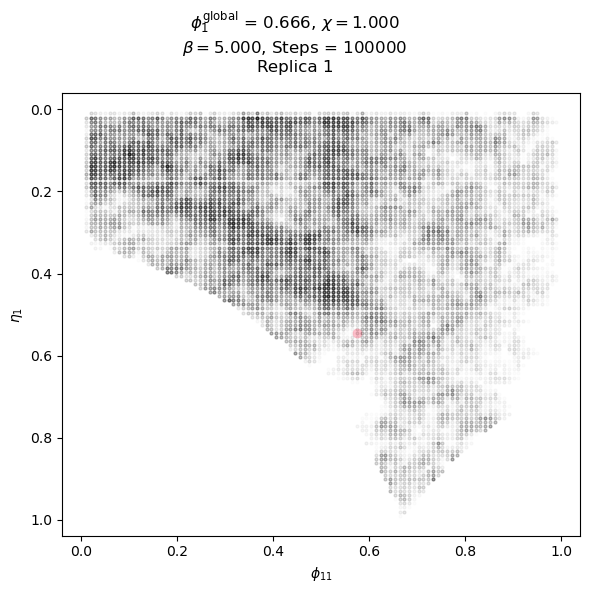

In [4]:
# Setting the mesh
size = 100 # (Indirectly) setting the resolution (1/size) of phi11 and eta1 plane

# Defining the system
# PHI_1_GLOBALs = np.linspace(1/size, 1 - (1/size), 10)
# CHIs = np.linspace(1, 3, 10)

PHI_1_GLOBALs = [0.666]
CHIs = [1]

# Walker Parameters
# BETAs = np.linspace(0.01, 5, 10)
BETAs = [5]
# NSTEPSs = [50000, 100000, 500000]
NSTEPSs  = [100000]
ctr = 0 # Counter tracks the the number of replicas of the system  for different starting phi11 and eta1 idxs


for CHI in tqdm(CHIs):
    for PHI_1_GLOBAL in PHI_1_GLOBALs:
        for beta in BETAs:
            for nSteps in NSTEPSs:
                ctr = 0
                while(ctr < 1):

                    df = pd.DataFrame()
                    
                    start_idx_phi_11 = np.random.randint(size) # Starting phi11 idx 
                    start_idx_eta_1 = np.random.randint(size) # Starting phi12 idx
                    
                    walker = mcmc(dof = 2, size = size, phi_1_global = PHI_1_GLOBAL, chi = CHI, beta = beta)
                    mesh = walker.createMesh()  
                    start_phi_12 = (PHI_1_GLOBAL - mesh[1][start_idx_eta_1]*mesh[0][start_idx_phi_11])/(1-mesh[1][start_idx_eta_1])

                    if (0 <= start_phi_12 <= 1):
                        # print(True)
                        ctr += 1
                        walk = walker.simulate(start_idx_phinp.random.randint(size)_11, start_idx_eta_1, nSteps)

                        df["(phi_11, eta_1)"] = walk

                        output_filepath = f"data/mesh-{size}/chi-{CHI:.3f}/phi_g-{PHI_1_GLOBAL:.3f}/beta-{beta:.3f}/steps-{nSteps}/df"
                        output_filename = f"replica-{ctr}.pkl"
                        
                        if not os.path.exists(output_filepath):
                            os.makedirs(output_filepath)
                        file = os.path.join(output_filepath, output_filename)    
                        df.to_pickle(file, compression='gzip')
                        
                        print(f"Saved @ {file}")

                        
                        phi_11 = []
                        eta_1 = []
                        
                        for idx, _ in enumerate(walk):
                            phi_11.append(mesh[0][_[0]])    
                            eta_1.append(mesh[1][_[1]])    
                        
                        fig, ax = plt.subplots(figsize = (6, 6))
                        
                        ax.scatter(mesh[0][start_idx_phi_11], mesh[1][start_idx_eta_1], color = "pink")
                        ax.scatter(phi_11, eta_1, alpha = 0.01, color = "k", s = 5)
                        ax.yaxis.set_inverted(True)
                        
                        ax.set_xlabel(r"$\phi_{11}$")
                        ax.set_ylabel(r"$\eta_1$")
                        title = r"$\phi_1^{\text{global}}$ = " + f"{PHI_1_GLOBAL:.3f}" + r", $\chi = $" + f"{CHI:.3f}" + "\n" + r"$\beta = $" + f"{beta:.3f}" + f", Steps = {nSteps}" + "\nReplica " + f"{ctr}"
                        fig.suptitle(title)
                        
                        fig.tight_layout()
                        
                        # output_filepath = f"data/mesh-{size}/chi-{CHI:.3f}/phi_g-{PHI_1_GLOBAL:.3f}/beta-{beta:.3f}/steps-{nSteps}/imgs"
                        # output_filename = f"replica-{ctr}.png"
                        
                        # if not os.path.exists(output_filepath):
                        #     os.makedirs(output_filepath)
                        
                        # file = os.path.join(output_filepath, output_filename)     
                        
                        # plt.savefig(file, dpi = 400)
                        # plt.close()
                        
                        # print(f"Saved @ {file}")
     
                    else:
                        ;
                        # print(False)